# Measuring the Runtime of Global Effect Plots  

This notebook analyzes the runtime $T(\cdot)$ of Global Effect plots, which depends on:  

- **$t_f$**: The time required to evaluate the black-box function $f$ on the entire dataset.  
- **$N$**: The number of instances in $X$.  
- **$D$**: The number of features in $X$.  
- **$K$**: The number of points used for centering the feature effect plot.  
- **$M$**: The number of evaluation points.  

The key factors affecting runtime are $t_f$, $N$, and $D$. Each method involves:  

1. **Preparing the permuted/augmented dataset**: This step depends only on $N$ and is repeated independently for each feature, so it contributes $D T_1(N)$ to the total runtime.  
2. **Predicting on the permuted dataset**: We here make the hypothesis, that $f(X)$ runs in $t_f$ independently of the number of instances. This is not generally true, however, it is a reasonable assumption as long as $f(X)$ can be computed in a single pass or some batches. Additionally, the prediction must be repeated independently for each feature, contributing $D T_2(t_f)$, except for RHALE, where all gradients are computed in a single pass, resulting in $T_2(t_f)$.  

Therefore, the runtime of each methods is: $$T(t_f, N, D) \approx D T_1(N) + T_2(t_f, D)$$.


Now, let's see all these effects in practice!

In [5]:
import effector
import numpy as np
import timeit
import time
import matplotlib.pyplot as plt
np.random.seed(21)

/Users/dimitriskyriakopoulos/Documents/ath/Effector/Code/eff-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
def return_predict(t):
    def predict(x):
        time.sleep(t)
        model = effector.models.DoubleConditionalInteraction()
        return model.predict(x)
    return predict

def return_jacobian(t):
    def jacobian(x):
        time.sleep(t)
        model = effector.models.DoubleConditionalInteraction()
        return model.jacobian(x)
    return jacobian

In [2]:
def measure_time(method_name, features, model, N, M, D, repetitions, K, model_jac=None,):
    fit_time_list, eval_time_list = [], []
    X = np.random.uniform(-1, 1, (N, D))
    xx = np.linspace(-1, 1, M)
    axis_limits = np.array([[-1] * D, [1] * D])

    method_map = {
        "pdp": effector.PDP,
        "d_pdp": effector.DerPDP,
        "ale": effector.ALE,
        "rhale": effector.RHALE,
        "shap_dp": effector.ShapDP
    }

    for _ in range(repetitions):
        # general kwargs
        method_kwargs = {"data": X, "model": model, "axis_limits": axis_limits, "nof_instances": "all"}
        fit_kwargs = {"features": features, "centering": True, "points_for_centering": K}

        # specialize kwargs per method
        if method_name in ["d_pdp", "rhale"]:
            method_kwargs["model_jac"] = model_jac
        if method_name in ["rhale", "ale"]:
            fit_kwargs["binning_method"] = effector.axis_partitioning.Fixed(nof_bins=20)

        # init
        method = method_map[method_name](**method_kwargs)

        # fit
        tic = time.time()
        method.fit(**fit_kwargs)
        fit_time_list.append(time.time() - tic)

        # eval
        tic = time.time()
        for feat in features:
            eval_kwargs = {"feature": feat, "xs": xx, "centering": True, "heterogeneity": True}
            method.eval(**eval_kwargs)
        eval_time_list.append(time.time() - tic)

    return {"fit": np.mean(fit_time_list), "eval": np.mean(eval_time_list), "total": (np.mean(fit_time_list) + np.mean(eval_time_list))}

In [3]:
import matplotlib.pyplot as plt

def bar_plot(xs, time_dict, methods, metric, title, xlabel, ylabel, bar_width=0.02):

    bar_width = (np.max(xs) - np.min(xs)) / 40
    method_to_label = {"ale": "ALE", "rhale": "RHALE", "pdp": "PDP", "d_pdp": "d-pdp", "shap_dp": "SHAP DP"}
    plt.figure()
    
    # Calculate the offsets for each bar group
    offsets = np.linspace(-2*bar_width, 2*bar_width, len(methods))
    
    for i, method in enumerate(methods):
        label = method_to_label[method]
        plt.bar(
            xs + offsets[i],
            [tt[metric] for tt in time_dict[method]],
            label=label,
            width=bar_width
        )
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(xs)
    plt.legend()
    plt.show()

## $T_1$: runtime vs N

### For one feature

In [4]:
t = 0.001
N = 10_000
D = 3
K = 100
M = 100
repetitions = 2
features=[0]

In [ ]:
method_names = ["ale", "rhale", "pdp", "d_pdp"]
vec = np.array([10_000, 25_000, 50_000])
time_dict = {method_name: [] for method_name in method_names}
for N in vec:
    model = return_predict(t)
    model_jac = return_jacobian(t)
    for method_name in method_names:
        time_dict[method_name].append(measure_time(method_name, features, model, N, M, D, repetitions, K, model_jac=model_jac))

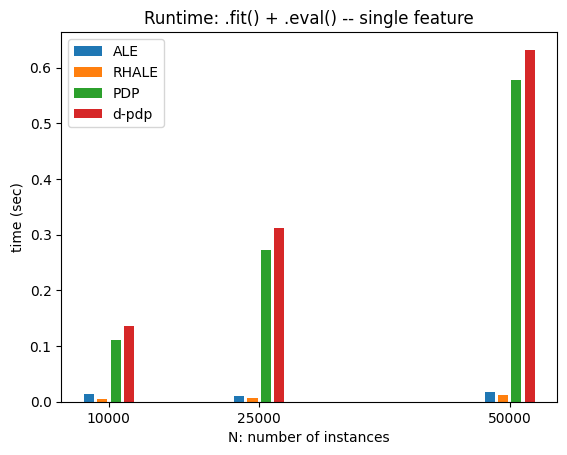

In [7]:
for metric in ["total"]: # ["fit", "eval", "total"]:
    if metric in ["fit", "eval"]:
        title = "Runtime: ." + metric + "() -- single feature"
    else:
        title = "Runtime: .fit() + .eval() -- single feature"
    
    bar_plot(
        vec, 
        time_dict, 
        method_names,
        metric=metric,
        title=title,
        xlabel="N: number of instances",
        ylabel="time (sec)"
)

### For all features

In [7]:
features=[i for i in range(D)]
method_names = ["ale", "rhale", "pdp", "d_pdp"]
vec = np.array([10_000, 25_000, 50_000])
time_dict = {method_name: [] for method_name in method_names}
for N in vec:
    model = return_predict(t)
    model_jac = return_jacobian(t)
    for method_name in method_names:
        time_dict[method_name].append(measure_time(method_name, features, model, N, M, D, repetitions, K, model_jac=model_jac))

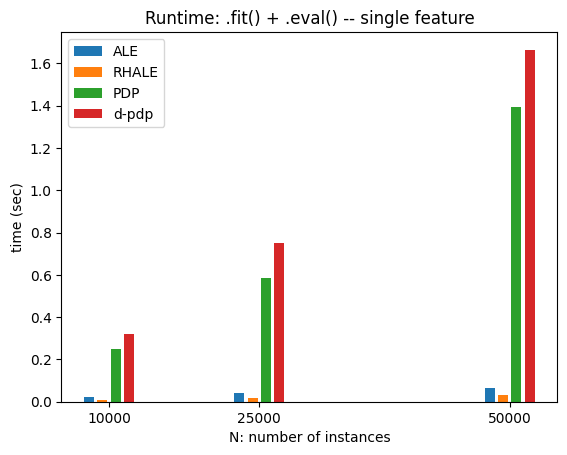

In [8]:
for metric in ["total"]: # ["fit", "eval", "total"]:
    if metric in ["fit", "eval"]:
        title = "Runtime: ." + metric + "() -- single feature"
    else:
        title = "Runtime: .fit() + .eval() -- single feature"
    
    bar_plot(
        vec, 
        time_dict, 
        method_names,
        metric=metric,
        title=title,
        xlabel="N: number of instances",
        ylabel="time (sec)"
)

### Conclusion

| Method        | `.fit()`     | `.eval()` | $T_1$ (single feature) | $T_1$ (all features)|
|--------------|-------------|-----------|----------------|-----------------------------------|
| **PDP / d-PDP** | $c_1 N$     | $c_2 N$    | $(c_1 + c_2) N$  | $D (c_1 + c_2) N$               |
| **ALE**       | $\epsilon$   | Free      | $\epsilon$       | $D \epsilon \approx 0$           |
| **RHALE**     | $\epsilon$   | Free      | $\epsilon$       | $D \epsilon \approx 0$           |

> Here, $c_1$ and $c_2$ are small but nonzero, meaning the runtime scales linearly with $N$ but remains low. In contrast, $\epsilon$ is extremely small, making ALE and RHALE effectively free in practice.  


## $T_2$: runtime vs. $t_f$:

To isolate the impact of $t_f$, we reduce $N$ to a small value. This assumes that the execution time of $f(X)$ remains constant regardless of the dataset size $X$. While this is not always true in general, it is a reasonable assumption for many ML models with vectorized implementations, as long as $f(X)$ can be computed in a single pass.

### For a single feature

In [9]:
t = 0.001
N = 1_000
D = 3
K = 100
M = 100
repetitions = 2
features=[0]

In [10]:
method_names = ["ale", "rhale", "pdp", "d_pdp"]
vec = np.array([.1, .5, 1.])
time_dict = {method_name: [] for method_name in method_names}
for t in vec:
    model = return_predict(t)
    model_jac = return_jacobian(t)
    for method_name in method_names:
        time_dict[method_name].append(measure_time(method_name, features, model, N, M, D, repetitions, K, model_jac=model_jac))

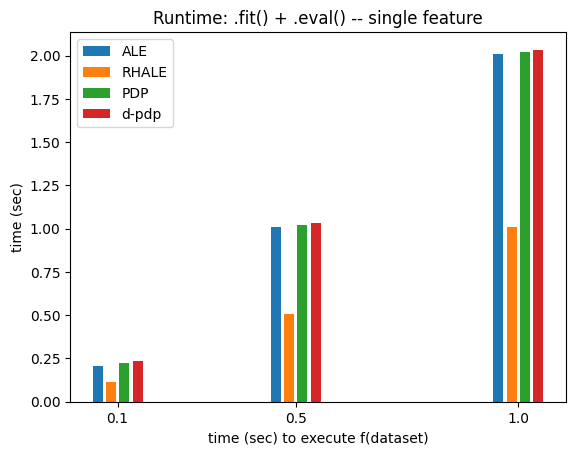

In [11]:
for metric in ["total"]: # ["fit", "eval", "total"]:
    if metric in ["fit", "eval"]:
        title = "Runtime: ." + metric + "() -- single feature"
    else:
        title = "Runtime: .fit() + .eval() -- single feature"
    
    bar_plot(
        vec, 
        time_dict, 
        method_names,
        metric=metric,
        title=title,
        xlabel="time (sec) to execute f(dataset)",
        ylabel="time (sec)"
)

### For all features 

In [12]:
t = 0.1
N = 10_000
D = 3
K = 100
M = 100
repetitions = 2


In [13]:
features=[i for i in range(D)]
method_names = ["ale", "rhale", "pdp", "d_pdp"]
vec = np.array([.1, .5, 1.])
time_dict = {method_name: [] for method_name in method_names}
for t in vec:
    model = return_predict(t)
    model_jac = return_jacobian(t)
    for method_name in method_names:
        time_dict[method_name].append(measure_time(method_name, features, model, N, M, D, repetitions, K, model_jac=model_jac))

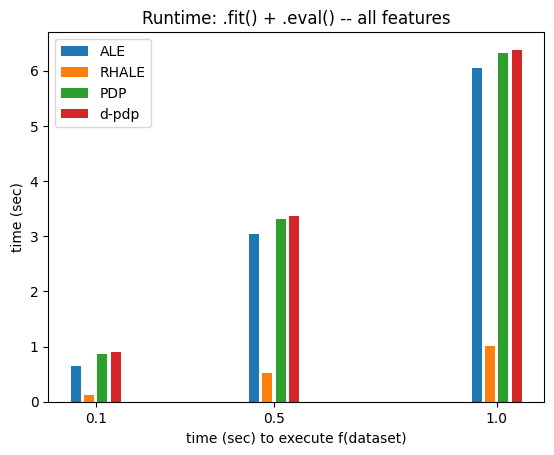

In [14]:
for metric in ["total"]: #["fit", "eval", "total"]:
    if metric in ["fit", "eval"]:
        title = "Runtime: ." + metric + "() -- all features"
    else:
        title = "Runtime: .fit() + .eval() -- all features"
    
    bar_plot(
        vec, 
        time_dict, 
        method_names,
        metric=metric,
        title=title,
        xlabel="time (sec) to execute f(dataset)",
        ylabel="time (sec)"
)

### Conclusion


| Method        | `.fit()`     | `.eval()` | $T_2$ (one feature)  | $T_2$ (all features) |
|---------------|--------------|-----------------------|------------------------|------------------------------------|
| **PDP / d-PDP** | $t_f$       | $t_f$                | $2t_f$                 | $2Dt_f$                      |
| **ALE**       | $2t_f$       | Free                  | $2t_f$                 | $2Dt_f$                             |
| **RHALE**     | $t_f$        | Free                  | $t_f$                   | $t_f$                              |

## Total Runtime

Adding the two parts, we have the total runtime:

| Method        | $T = T_1 + T_2$ (one feature) | $T = T_1 + T_2$ (all features) |
|---------------|-------------------------------|--------------------------------|
| **PDP / d-PDP** | $(c_1 + c_2) N + 2 t_f$       | $D (c_1 + c_2) N + 2 D t_f$    |
| **ALE**       | $2 t_f$             | $2 D t_f$         |
| **RHALE**     | $t_f$               | $t_f$             |